## Lab 4: Wrangling Text Data
XBUS-511: Diagnostics for More Informed Machine Learning

In this exercise, we will be exploring a large corpus of 373 ingested RSS feeds containing 24,867 posts in 12 categories.

### Category Counts

- books: 712 (42.5MiB)
- business: 3725 (375.0MiB)
- cinema: 1074 (93.7MiB)
- cooking: 322 (29.6MiB)
- data_science: 364 (14.9MiB)
- design: 484 (33.0MiB)
- do_it_yourself: 1265 (85.4MiB)
- gaming: 1075 (77.3MiB)
- news: 11624 (1.2GiB)
- politics: 1456 (133.3MiB)
- sports: 1104 (154.4MiB)
- tech: 1662 (136.7MiB)

*Note: This corpus is intended to be used for academic purposes only, and I expect you to use it as though you downloaded it from the RSS feeds yourself. What does that mean? Well it means that the copyright of each individual document is the copyright of the owner who gives you the ability to download a copy for yourself for reading/analysis etc. I expect that you'll respect the copyright and not republish this corpus or use it for anything other than tutorial analysis.*



## Imports

In [1]:
import os
import nltk
import time
import json
import pickle
import zipfile
import warnings
import requests
import tabulate
import unicodedata
import numpy as np
import pandas as pd

from pprint import pprint
from collections import Counter

from nltk.corpus import wordnet as wn
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus.reader.api import CorpusReader
from nltk.corpus.reader.api import CategorizedCorpusReader
from nltk import pos_tag, sent_tokenize, wordpunct_tokenize

from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split as tts
from sklearn.feature_extraction.text import TfidfVectorizer

from yellowbrick.text import TSNEVisualizer, UMAPVisualizer
warnings.filterwarnings('ignore')

## Fetch the Data

In [2]:
# Make sure the fixtures path exists
FIXTURES = os.path.join("..", "fixtures")
if not os.path.exists(FIXTURES):
    os.makedirs(FIXTURES)
    
# Make sure the results path exists
RESULTS = os.path.join("..", "results", "baleen")
if not os.path.exists(RESULTS):
    os.makedirs(RESULTS)

In [3]:
def fetch_data(url, fname):
    """
    Helper method to retrieve data.
    """
    response = requests.get(url)
    outpath  = os.path.abspath(fname)
    with open(outpath, "wb") as f:
        f.write(response.content)
    
    return outpath

In [4]:
# Fetch and unzip the data
URL = "https://s3.amazonaws.com/ddl-data-lake/baleen/sample.zip"
ZIPPED_CORPUS = "sample.zip"
UNZIPPED_CORPUS = "baleen"

zipped_data = fetch_data(
    URL, 
    os.path.join(FIXTURES, ZIPPED_CORPUS)
)

with zipfile.ZipFile(
    os.path.join(FIXTURES, ZIPPED_CORPUS), "r"
) as zfiles:
    zfiles.extractall(
        os.path.join(FIXTURES, UNZIPPED_CORPUS)
    )

In [5]:
PICKLED_CORPUS = os.path.join(
    FIXTURES, 
    UNZIPPED_CORPUS,
    "sample"
)

In [6]:
SCORES = os.path.join(RESULTS, "scores.json") 

In [7]:
labels = [
    "books", 
    "cinema", 
    "cooking", 
    "gaming", 
    "sports", 
    "tech",
    "design",
    "business"
]

## Create a Streaming Corpus Reader 

In [8]:
DOC_PATTERN = r'(?!\.)[a-z_\s]+/[a-f0-9]+\.json'
PKL_PATTERN = r'(?!\.)[a-z_\s]+/[a-f0-9]+\.pickle'
CAT_PATTERN = r'([a-z_\s]+)/.*'


class PickledCorpusReader(CategorizedCorpusReader, CorpusReader):

    def __init__(self, root, fileids=PKL_PATTERN, **kwargs):
        """
        Initialize the corpus reader.  Categorization arguments
        (``cat_pattern``, ``cat_map``, and ``cat_file``) are
        passed to the ``CategorizedCorpusReader`` constructor.
        The remaining arguments are passed to the 
        ``CorpusReader`` constructor.
        """
        # Add  default category pattern if not passed into class.
        if not any(key.startswith('cat_') for key in kwargs.keys()):
            kwargs['cat_pattern'] = CAT_PATTERN

        CategorizedCorpusReader.__init__(self, kwargs)
        CorpusReader.__init__(self, root, fileids)

    def _resolve(self, fileids, categories):
        """
        Returns a list of fileids or categories depending on what
        is passed to each internal corpus reader function. This
        primarily bubbles up to the high level ``docs`` method,
        but is implemented here similar to the nltk
        ``CategorizedPlaintextCorpusReader``.
        """
        if fileids is not None and categories is not None:
            raise ValueError("Specify fileids or categories, not both")

        if categories is not None:
            return self.fileids(categories)
        return fileids

    def docs(self, fileids=None, categories=None):
        """
        Returns the document loaded from a pickled object
        for every file in the corpus. Uses a generator to 
        achieve memory safe iteration.
        """
        # Resolve the fileids and the categories
        fileids = self._resolve(fileids, categories)

        # Create a generator, loading one doc into memory at a time.
        for path, enc, fileid in self.abspaths(fileids, True, True):
            with open(path, 'rb') as f:
                yield pickle.load(f)

    def paras(self, fileids=None, categories=None):
        """
        Returns a generator of paragraphs where each paragraph
        is a list of sentences, which is in turn a list of
        (token, tag) tuples.
        """
        for doc in self.docs(fileids, categories):
            for paragraph in doc:
                yield paragraph

    def sents(self, fileids=None, categories=None):
        """
        Returns a generator of sentences where each
        sentence is a list of (token, tag) tuples.
        """
        for paragraph in self.paras(fileids, categories):
            for sentence in paragraph:
                yield sentence

    def tagged(self, fileids=None, categories=None):
        for sent in self.sents(fileids, categories):
            for token in sent:
                yield token

    def words(self, fileids=None, categories=None):
        """
        Returns a generator of (token, tag) tuples.
        """
        for token in self.tagged(fileids, categories):
            yield token[0]

In [9]:
# Get the unique words and total words
corpus = PickledCorpusReader(PICKLED_CORPUS)
words  = Counter(corpus.words())
print("{:,} vocabulary {:,} word count".format(
    len(words.keys()), 
    sum(words.values())
))

58,748 vocabulary 1,624,862 word count


## Break into Train and Test Splits

In [10]:
class CorpusLoader(object):

    def __init__(
        self, 
        reader, 
        folds=12,
        shuffle=True, 
        categories=None
    ):
        self.reader = reader
        self.folds = KFold(n_splits=folds, shuffle=shuffle)
        self.files = np.asarray(
            self.reader.fileids(categories=categories)
        )

    def fileids(self, idx=None):
        if idx is None:
            return self.files
        return self.files[idx]

    def documents(self, idx=None):
        for fileid in self.fileids(idx):
            yield list(self.reader.docs(fileids=[fileid]))

    def labels(self, idx=None):
        return [
            self.reader.categories(fileids=[fileid])[0]
            for fileid in self.fileids(idx)
        ]

    def load_all(self, idx=None):
        return list(self.documents()), list(self.labels())
    
    def __iter__(self):
        for train_index, test_index in self.folds.split(self.files):
            X_train = self.documents(train_index)
            y_train = self.labels(train_index)

            X_test = self.documents(test_index)
            y_test = self.labels(test_index)

            yield X_train, X_test, y_train, y_test

## Normalize the Data

Remove stopwords and perform lemmatization

In [11]:
class TextNormalizer(BaseEstimator, TransformerMixin):

    def __init__(self, language='english'):
        self.stopwords  = set(nltk.corpus.stopwords.words(language))
        self.lemmatizer = WordNetLemmatizer()

    def is_punct(self, token):
        return all(
            unicodedata.category(char).startswith('P') 
            for char in token
        )

    def is_stopword(self, token):
        return token.lower() in self.stopwords

    def normalize(self, document):
        return [
            self.lemmatize(token, tag).lower()
            for paragraph in document
            for sentence in paragraph
            for (token, tag) in sentence
            if not self.is_punct(token)
            and not self.is_stopword(token)
        ]

    def lemmatize(self, token, pos_tag):
        tag = {
            'N': wn.NOUN,
            'V': wn.VERB,
            'R': wn.ADV,
            'J': wn.ADJ
        }.get(pos_tag[0], wn.NOUN)

        return self.lemmatizer.lemmatize(token, tag)

    def fit(self, X, y=None):
        return self

    def transform(self, documents):
        for document in documents:
            yield self.normalize(document[0])

## Make a Pipeline

In [12]:
def identity(words):
    return words

def create_pipeline(estimator, reduction=False):

    steps = [
        ('normalize', TextNormalizer()),
        ('vectorize', TfidfVectorizer(
            tokenizer=identity, preprocessor=None, lowercase=False
        ))
    ]

    if reduction:
        steps.append((
            'reduction', TruncatedSVD(n_components=10000)
        ))

    # Add the estimator
    steps.append(('classifier', estimator))
    return Pipeline(steps)

## Make a scoring function

In [13]:
def score_models(models, loader):
    for model in models:

        name = model.named_steps['classifier'].__class__.__name__
        if 'reduction' in model.named_steps:
            name += " (TruncatedSVD)"

        scores = {
            'model': str(model),
            'name': name,
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': [],
            'time': [],
        }

        for X_train, X_test, y_train, y_test in loader:
            start = time.time()
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            scores['time'].append(time.time() - start)
            scores['accuracy'].append(
                accuracy_score(y_test, y_pred)
            )
            scores['precision'].append(
                precision_score(
                    y_test, 
                    y_pred, 
                    average='weighted'
                )
            )
            scores['recall'].append(
                recall_score(
                    y_test, 
                    y_pred, 
                    average='weighted'
                )
            )
            scores['f1'].append(
                f1_score(
                    y_test, 
                    y_pred, 
                    average='weighted'
                )
            )

        yield scores

### Prepare an array of model pipelines to compare

In [14]:
models = []
for form in (LogisticRegression, SGDClassifier):
    models.append(create_pipeline(form(), True))
    models.append(create_pipeline(form(), False))

models.append(create_pipeline(MultinomialNB(), False))
models.append(create_pipeline(GaussianNB(), True))

### Instantiate our corpus

In [15]:
reader = PickledCorpusReader(PICKLED_CORPUS)
loader = CorpusLoader(
    reader, 
    folds=5, 
    shuffle=True, 
    categories=labels
)


### Fit and score our models

In [16]:
for scores in score_models(models, loader):
    with open(SCORES, 'a') as f:
        f.write(json.dumps(scores) + "\n")

### View the tabulated results

In [17]:
fields = ['model', 'precision', 'recall', 'accuracy', 'f1']
table = []

with open(SCORES, 'r') as f:
    for idx, line in enumerate(f):
        scores = json.loads(line)

        row = [scores['name']]
        for field in fields[1:]:
            row.append(
                "{:0.3f}".format(np.mean(scores[field]))
            )

        table.append(row)

table.sort(key=lambda r: r[-1], reverse=True)
print(tabulate.tabulate(table, headers=fields))

model                                precision    recall    accuracy     f1
---------------------------------  -----------  --------  ----------  -----
SGDClassifier                            0.781     0.78        0.78   0.774
SGDClassifier (TruncatedSVD)             0.778     0.754       0.754  0.75
LogisticRegression                       0.675     0.598       0.598  0.549
LogisticRegression (TruncatedSVD)        0.657     0.584       0.584  0.53
GaussianNB (TruncatedSVD)                0.39      0.356       0.356  0.271
MultinomialNB                            0.133     0.365       0.365  0.195


## TSNE and UMAP

We can use these visualizations to reflect on the quality of our predictions. How unique are the categories are? Should we remove some any? Combine any?

One very popular method for visualizing document similarity is to use t-distributed stochastic neighbor embedding, [t-SNE](https://www.scikit-yb.org/en/develop/api/text/tsne.html). Scikit-learn implements this decomposition method as the sklearn.manifold.TSNE transformer. By decomposing high-dimensional document vectors into 2 dimensions using probability distributions from both the original dimensionality and the decomposed dimensionality, t-SNE is able to effectively cluster similar documents. By decomposing to 2 or 3 dimensions, the documents can be visualized with a scatter plot. The TSNEVisualizer creates an inner transformer pipeline that applies an SVD decomposition first, then performs the t-SNE embedding. The visualizer then plots the scatter plot, coloring by cluster or by class, or neither if a structural analysis is required.

[Uniform Manifold Approximation and Projection (UMAP)](https://www.scikit-yb.org/en/develop/api/text/umap_vis.html) is a nonlinear dimensionality reduction method that is well suited to embedding in two or three dimensions for visualization as a scatter plot. UMAP is a relatively new technique but is very effective for visualizing clusters or groups of data points and their relative proximities. It does a good job of learning the local structure within your data but also attempts to preserve the relationships between your groups as can be seen in its exploration of MNIST. It is fast, scalable, and can be applied directly to sparse matrices, eliminating the need to run TruncatedSVD as a pre-processing step. Additionally, it supports a wide variety of distance measures allowing for easy exploration of your data.

In [18]:
pipe = Pipeline([
    ('normalize', TextNormalizer()),
    ('vectorize', TfidfVectorizer(
        tokenizer=identity, preprocessor=None, lowercase=False
    ))
])

reader = PickledCorpusReader(PICKLED_CORPUS)
loader = CorpusLoader(
    reader,
    shuffle=True,
    categories=labels
)
docs, y = loader.load_all()

In [19]:
X = pipe.fit_transform(docs)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

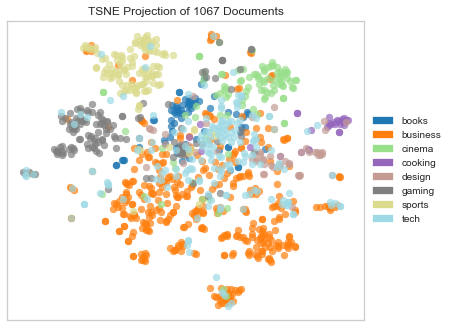

<AxesSubplot:title={'center':'TSNE Projection of 1067 Documents'}>

In [20]:
# Create the visualizer and draw the vectors
tsne = TSNEVisualizer(colormap="tab20")
tsne.fit(X, y)
tsne.show()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

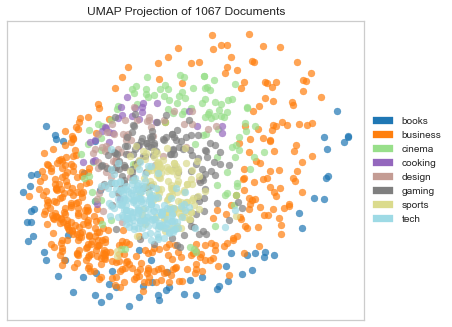

<AxesSubplot:title={'center':'UMAP Projection of 1067 Documents'}>

In [21]:
# Create the visualizer and draw the vectors
umap = UMAPVisualizer(colormap="tab20")
umap.fit(X, y)
umap.show()